In [ ]:
from cathedral_rl import cathedral_v0  
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch.nn.functional as F
import math
import copy
from cathedral_rl.game.board import Board 

### Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        return state, action, reward, next_state, done, action_mask, next_action_mask
        
    def __len__(self):
        return len(self.buffer)    


In [ ]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity  # Nombre maximum de transitions
        self.tree = np.zeros(2 * capacity - 1)  # Arbre sous forme d'un tableau
        self.data = [None] * capacity  # Stockage des transitions
        self.write = 0  # Position d'écriture
        self.n_entries = 0  # Nombre d'entrées actuellement stockées

    def add(self, priority, data):
        """Ajoute une transition avec sa priorité dans l'arbre."""
        idx = self.write + self.capacity - 1  # Calcul de l'indice dans l'arbre
        self.data[self.write] = data
        self.update(idx, priority)
        
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        """Met à jour la priorité à l'indice idx et remonte la différence dans l'arbre."""
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        
        # Remonter dans l'arbre
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, s):
        """
        Renvoie (leaf_index, priority, data) pour une valeur s donnée, 
        où s est un nombre aléatoire dans [0, total_priority).
        """
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf_idx = idx
                break
            else:
                if s <= self.tree[left]:
                    idx = left
                else:
                    s -= self.tree[left]
                    idx = right
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_priority(self):
        return self.tree[0]


In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: nombre maximum de transitions à stocker
        alpha: degré de prioritisation (0 correspond à un échantillonnage uniforme)
        """
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)

    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """
        Ajoute une transition dans le buffer.
        La priorité initiale est fixée au maximum actuellement présent pour garantir que la transition soit échantillonnée.
        """
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        # Si le buffer est vide, on fixe la priorité à 1 par défaut
        max_priority = np.max(self.tree.tree[-self.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(max_priority, transition)

    def sample(self, batch_size, beta=0.4):
        """
        Échantillonne un batch de transitions en utilisant les priorités.
        beta: coefficient pour corriger le biais d'échantillonnage par importance sampling.
        Renvoie un tuple : (états, actions, récompenses, next_states, done_flags, action_masks, next_action_masks, indices, poids_IS)
        """
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total_priority / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append(data)
            priorities.append(p)
            idxs.append(idx)

        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        total = self.tree.total_priority
        probs = np.array(priorities) / total
        # Poids d'importance
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max()  # Normalisation pour stabiliser les gradients
        
        return state, action, reward, next_state, done, action_mask, next_action_mask, idxs, weights

    def update_priorities(self, idxs, priorities):
        """
        Met à jour les priorités des transitions échantillonnées après calcul de l'erreur TD.
        """
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority ** self.alpha)

    def __len__(self):
        return self.tree.n_entries


### Model

In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        # observations : (10, 10, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1),  # output: 32 x 10 x 10
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # output: 64 x 10 x 10
            nn.ReLU(),
            nn.Flatten()
        )
        
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_actions)
        )
        
    def forward(self, x):
        # x(batch, hauteur, largeur, channels)
        x = x.permute(0, 3, 1, 2)  
        x = self.conv(x)
        x = self.fc(x)
        return x


### Functions

### Training

In [ ]:
num_episodes = 50
buffer_capacity = 800
batch_size = 64
gamma = 0.999
learning_rate = 1e-3
board_size = 10

factor_illegal_action = 1

parameters_updates = 10    # plusieurs mises à jour par épisode
target_update_freq = 20    # fréquence (en épisodes) de mise à jour du réseau cible
opponent_update_freq = 100

epsilon_start = 0.3
epsilon_final = 0.1
epsilon_decay = 100    
epsilon_opponent = 0.1  # faible exploration pour l'adversaire  

controlled_agent = "player_0" 
method = "eps_greedy"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')


def epsilon_by_episode(episode):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-episode / epsilon_decay)

def temperature_by_episode(episode):
    return 1

    

device : cuda


In [ ]:
def create_networks(obs_shape, n_actions):
    policy_net = DQN(obs_shape, n_actions).to(device)
    target_net = DQN(obs_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    opponent_net = DQN(obs_shape, n_actions).to(device)
    opponent_net.load_state_dict(policy_net.state_dict())
    
    return policy_net, target_net, opponent_net

def compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor):
    
    with torch.no_grad():
        next_q_policy = policy_net(next_states_tensor)  # [batch_size, n_actions]
        next_q_policy[~next_action_masks_tensor] = -1e8
        next_actions = next_q_policy.argmax(dim=1, keepdim=True)  # [batch_size, 1]

        next_q_target = target_net(next_states_tensor)
        next_q_target[~next_action_masks_tensor] = -1e8
        next_q_values = next_q_target.gather(1, next_actions).squeeze(1)

        mask_sum = next_action_masks_tensor.sum(dim=1)
        next_q_values[mask_sum == 0] = 0.0

        target_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)
        
        return target_q_values

In [ ]:
def select_action_dqn(model, obs, action_mask, legal_moves, episode, device, method, verbose=False):
    model.eval()
    not_legal_action = 0
    with torch.no_grad():
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 10, 10, 5)
        q_values = model(obs_tensor).squeeze(0)  # (n_actions,)
        
        if method == 'eps_greedy':
            epsilon = epsilon_by_episode(episode) # epsilon-greedy
            if random.random() < epsilon:
                action = random.choice(legal_moves)
                not_legal_action = 0
            else:
                first_action = torch.argmax(q_values).item()
                mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
                q_values[~mask] = -1e8
                action = torch.argmax(q_values).item()
                not_legal_action = int(first_action != action)
        
        elif method == 'boltzmann':
            temperature = temperature_by_episode(episode)
            first_action = torch.argmax(q_values).item()
            mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
            q_values[~mask] = -1e8
            action = torch.argmax(q_values).item()
            not_legal_action = int(first_action != action)
            probabilities = F.softmax(q_values / temperature, dim=-1)
            action = torch.multinomial(probabilities, num_samples=1).item()
        
            
            
    model.train()
    return action, not_legal_action

In [ ]:
def train_dqn(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
    env.reset()
    
    enter_train = False
    n_actions = env.action_space(controlled_agent).n
    print(f'n_actions : {n_actions}')
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)

    policy_net, target_net, opponent_net = create_networks(obs_shape, n_actions)
    
    target_net.eval()
    opponent_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    # replay_buffer = ReplayBuffer(buffer_capacity)
    replay_buffer = PrioritizedReplayBuffer(buffer_capacity, alpha=0.6)

    list_reward = []
    list_epsilon = []
    policy_net_checkpoints = []
    win_count = 0
    for episode in range(num_episodes):
        env.reset()
        total_reward = 0
        losses = []
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == controlled_agent:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                action, not_legal_action = select_action_dqn(policy_net, state, action_mask, legal_moves, episode, device, method=method)
                
                env.step(action)
                reward = env.rewards[current_agent]
                # reward -= factor_illegal_action * not_legal_action
                # print(f'reward: {reward}')
                total_reward += reward

                # next_state, next_action_mask, done_flag = get_next_state_for_controlled(env, controlled_agent, state, action_mask)
                if controlled_agent in env.agents:
                    next_obs = env.observe("player_1")
                    next_state = next_obs["observation"]
                    next_action_mask = next_obs["action_mask"]
                    done_flag = 0
                else:
                    next_state = np.zeros_like(state)
                    next_action_mask = np.zeros_like(action_mask)
                    done_flag = 1
                
                replay_buffer.push(state, action, reward, next_state, done_flag, action_mask, next_action_mask)
                
            else:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                action, not_legal_action = select_action_dqn(opponent_net, state, action_mask, legal_moves, episode, device, method=method)
                    
                env.step(action)
        
            if len(replay_buffer) >= batch_size:
                enter_train = True
                
                for _ in range(parameters_updates):  
                    states, actions, rewards, next_states, dones, action_masks, next_action_masks, _, _ = replay_buffer.sample(batch_size)
                    
                    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                    actions_tensor = torch.tensor(actions, dtype=torch.long).to(device)
                    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                    next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                    dones_tensor = torch.tensor(dones, dtype=torch.float32).to(device)
                    next_action_masks_tensor = torch.tensor(next_action_masks, dtype=torch.bool).to(device)
                    
                    # Q-valeurs actuelles pour les actions sélectionnées
                    q_values = policy_net(states_tensor)
                    q_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    
                    target_q_values = compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor)
                
                    loss = nn.MSELoss()(q_values, target_q_values)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())
        
        winner = env.winner
        list_reward.append(total_reward)
        if winner == 0:  # ("player_0") wins
            win_count += 1
        elif winner == -1:  # draw
            win_count += 0.5
        
        
        if enter_train:
            print(f"Episode {episode+1}/{num_episodes} - Reward total: {total_reward:.2f} - Loss: {sum(losses)/len(losses):.4f} - Winner: {winner} - Epsilon: {epsilon_by_episode(episode):.2f}")
        
        if (episode+1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print("Update target_net")
            
        if (episode+1) % opponent_update_freq == 0:
            policy_net_checkpoints.append(policy_net.state_dict())
            opponent_net.load_state_dict(policy_net.state_dict())
            print("Update opponent_net")    
        
    env.close()

    torch.save({
        'model_state_dict': policy_net.state_dict(),
        'list_reward': list_reward,
        'list_epsilon': list_epsilon,
        'policy_net_checkpoints': policy_net_checkpoints,
        'num_checkpoints' : len(policy_net_checkpoints)
    }, f"model_weights_DQN/{name}.pth")
    
    print(f'Winrate : {win_count/num_episodes}')
    
    return list_reward, list_epsilon

In [ ]:
list_reward, list_epsilon = train_dqn('test5')

n_actions : 1753
Episode 7/50 - Reward total: 0.00 - Loss: 0.0020 - Winner: 1 - Epsilon: 0.29
Episode 8/50 - Reward total: 0.00 - Loss: 0.0002 - Winner: -1 - Epsilon: 0.29
Episode 9/50 - Reward total: 0.00 - Loss: 0.0003 - Winner: 1 - Epsilon: 0.28
Episode 10/50 - Reward total: 0.00 - Loss: 0.0003 - Winner: 1 - Epsilon: 0.28
Episode 11/50 - Reward total: 0.00 - Loss: 0.0004 - Winner: 1 - Epsilon: 0.28
Episode 12/50 - Reward total: 0.00 - Loss: 0.0004 - Winner: 1 - Epsilon: 0.28
Episode 13/50 - Reward total: 0.00 - Loss: 0.0005 - Winner: 1 - Epsilon: 0.28
Episode 14/50 - Reward total: 0.00 - Loss: 0.0006 - Winner: -1 - Epsilon: 0.28
Episode 15/50 - Reward total: 0.00 - Loss: 0.0006 - Winner: 1 - Epsilon: 0.27
Episode 16/50 - Reward total: 0.00 - Loss: 0.0006 - Winner: 1 - Epsilon: 0.27
Episode 17/50 - Reward total: 0.00 - Loss: 0.0005 - Winner: 1 - Epsilon: 0.27
Episode 18/50 - Reward total: 1.00 - Loss: 0.0011 - Winner: 0 - Epsilon: 0.27
Episode 19/50 - Reward total: 1.00 - Loss: 0.004

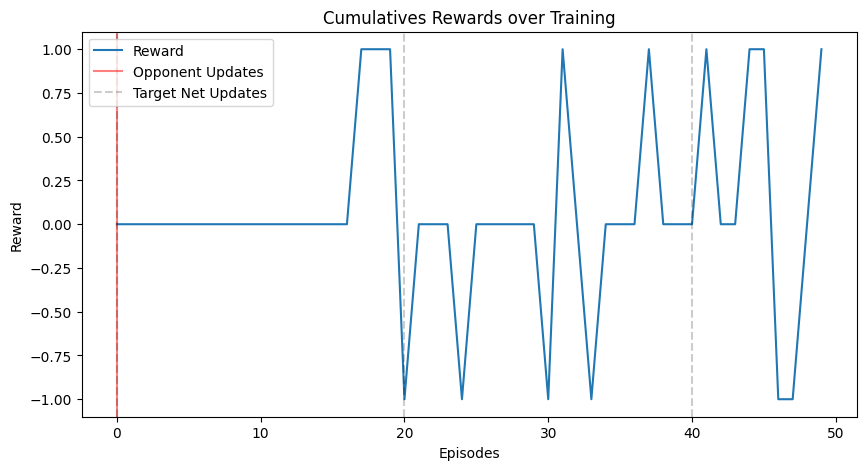

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list_reward, label="Reward")
for i in range(0, len(list_reward), opponent_update_freq):
    if i == 0:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5, label="Opponent Updates")
    else:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5)

for i in range(0, len(list_reward), target_update_freq):
    if i == 0:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2, label="Target Net Updates")
    else:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2)
    
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Cumulatives Rewards over Training")
plt.legend()
plt.show()

### Evaluate

In [ ]:
env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
env.reset()

n_actions = env.action_space(controlled_agent).n
obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)
list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0

checkpoint = torch.load("model_weights_DQN/test5.pth", weights_only=False)

policy_net = DQN(obs_shape, n_actions).to(device)
policy_net.load_state_dict(checkpoint['model_state_dict'])
opponent_net = DQN(obs_shape, n_actions).to(device)
opponent = 0

list_reward_training = checkpoint['list_reward']
policy_net_checkpoints = checkpoint['policy_net_checkpoints']
num_checkpoints = checkpoint['num_checkpoints']
print(f'Num checkpoints: {num_checkpoints}')

list_reward = []
win_count = 0
print(f"Opponent {opponent} / {num_checkpoints}")
# opponent_net.load_state_dict(policy_net_checkpoints[opponent])
opponent_net.load_state_dict(policy_net.state_dict())

env.reset()
total_reward = 0

while env.agents:
    current_agent = env.agent_selection
    observation = env.observe(current_agent)
    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    
        
    if current_agent == controlled_agent:
        state = observation["observation"]
        action_mask = observation["action_mask"]
        action, _ = select_action_dqn(opponent_net, state, action_mask, legal_moves, 0, device, method=method)
                    
        env.step(action)
        
        reward = env.rewards[current_agent]
        total_reward += reward
        list_reward.append(total_reward)
    else: 
        state = observation["observation"]
        action_mask = observation["action_mask"]
        action, _ = select_action_dqn(opponent_net, state, action_mask, legal_moves, 0, device, method=method)
                    
        # print(f'action : {action}')
        env.step(action)
    
    
    print(f"Current agent: {current_agent} Action: {action}")
    print("== REWARD ==")
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print("== RENDER ==")
    env.render()
    print('\n')
print(f"Opponent: {opponent} / Winnner: {env.winner}")


Num checkpoints: 0
Opponent 0 / 0
Current agent: player_0 Action: 1647
== REWARD ==
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
== RENDER ==
Board: 
 [[0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 3. 3. 3.]
 [0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Territory: 
 [[-1. -1. -1. -1. -1. -1.  0. nan]
 [-1. -1. -1. -1. -1. -1.  0. nan]
 [-1. -1. -1. -1. -1.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1.  0. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


Current agent: player_1 Action: 163
== REWARD ==
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
== RENDER ==
Board: 
 [[0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 2. 0. 0. 3. 3. 3.]
 [0. 0. 2. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0

In [ ]:
def evaluate_DQN(name, opponents, num_episodes_eval=100, epsilon=0.15):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()

    n_actions = env.action_space(controlled_agent).n
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)
    list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0
    
    checkpoint = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

    policy_net = DuelingDQN(obs_shape, n_actions).to(device)
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    opponent_net = DuelingDQN(obs_shape, n_actions).to(device)
    opponents.append(-2)
    
    list_reward_training = checkpoint['list_reward']
    policy_net_checkpoints = checkpoint['policy_net_checkpoints']
    num_checkpoints = checkpoint['num_checkpoints']
    print(f'Num checkpoints: {num_checkpoints}')
    
    for opponent in opponents:
        list_reward = []
        win_count = 0
        print(f"Opponent {opponent} / {num_checkpoints}")
        if opponent != -2:
            opponent_net.load_state_dict(policy_net_checkpoints[opponent])
        else:
            opponent_net.load_state_dict(policy_net.state_dict())
            
        for episode in tqdm(range(num_episodes_eval)):
            env.reset()
            total_reward = 0

            while env.agents:
                current_agent = env.agent_selection
                observation = env.observe(current_agent)
                legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
                
                    
                if current_agent == controlled_agent:
                    state = observation["observation"]
                    action_mask = observation["action_mask"]
                    action, _ = select_action_dqn(policy_net, state, action_mask, device, verbose=True)
                    env.step(action)
                    
                    reward = env.rewards[current_agent]
                    total_reward += reward
                    list_reward.append(total_reward)
                else: 
                    if opponent == -1: # random opponent
                        action = random.choice(legal_moves)
                    else:
                        if random.random() < epsilon:
                            action = random.choice(legal_moves)
                        else:
                            state = observation["observation"]
                            action_mask = observation["action_mask"]
                            action, _ = select_action_dqn(opponent_net, state, action_mask, device)
                        
                        # print(f'action : {action}')
                    env.step(action)
                        
            if env.winner == 0: # controlled_agent ("player_0") gagne
                win_count += 1
            elif env.winner == -1: # match nul : on peut compter 0.5 victoire
                win_count += 0.5
        
        avg_reward = sum(list_reward)/len(list_reward)
        print(f"Opponent {opponent} : {num_episodes_eval} episodes => Avg Reward : {avg_reward:.4f} // Winrate : {win_count/num_episodes_eval:.4f}")
        

In [ ]:
avg_reward = evaluate_DQN('test3', [-1, 0, 1, 2, 3, -2])
#89%

Num checkpoints: 4
Opponent -1 / 4


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Opponent -1 : 100 episodes => Avg Reward : 0.8993288590604027 // Winrate : 0.935
Opponent 0 / 4


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


Opponent 0 : 100 episodes => Avg Reward : 0.03163265306122449 // Winrate : 0.69
Opponent 1 / 4


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Opponent 1 : 100 episodes => Avg Reward : -0.20184426229508196 // Winrate : 0.705
Opponent 2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Opponent 2 : 100 episodes => Avg Reward : -0.17426545086119555 // Winrate : 0.66
Opponent 3 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Opponent 3 : 100 episodes => Avg Reward : 0.07520325203252033 // Winrate : 0.74
Opponent -2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Opponent -2 : 100 episodes => Avg Reward : -0.07222787385554426 // Winrate : 0.735
Opponent -2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]

Opponent -2 : 100 episodes => Avg Reward : 0.04294478527607362 // Winrate : 0.68
